Data Cleaning Pipeline

In [8]:
import rsf_occupancy_collector as rsf
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns 
import plotly.express as px

In [9]:
def get_df():
    sheet = rsf.setup_google_sheets()
    values = sheet.get_all_values()
    headers = values[0]
    rsf_df = pd.DataFrame(values[1:], columns=headers)
    return rsf_df

def filter_gym_data():
    #Only keep data points recorded after spring break (>= 31st)
    df = get_df()
    date_format = '%m/%d/%Y %I:%M:%p'
    #Convert columns to consistent datatypes
    df['pst_timestamp'] = pd.to_datetime(df['pst_timestamp'], format=date_format)
    df['percentage_capacity'] = df['percentage_capacity'].astype(float)
    spring_break_end = pd.Timestamp('2025-03-31')
    df = df[df['pst_timestamp'] >= spring_break_end]
    #Only keep data points recorded within hours of operation (due to issues with github workflow)
    df = df[(df['pst_timestamp'].dt.hour >= 7) & (df['pst_timestamp'].dt.hour < 23)]
    #Remove data points where the gym is 0% full
    df = df[df['percentage_capacity'] > 0]
    return df

data = filter_gym_data()

In [10]:
#Each row represents a reading from the RSF crowd meter sensor starting from March 31st 2025
data

,timestamp,percentage_capacity,pst_timestamp
374,2025-03-31 15:19:18,48.00,2025-03-31 08:19:00
375,2025-03-31 15:37:08,56.00,2025-03-31 08:37:00
376,2025-03-31 15:47:45,54.67,2025-03-31 08:47:00
377,2025-03-31 16:22:56,56.67,2025-03-31 09:22:00
378,2025-03-31 16:52:37,53.33,2025-03-31 09:52:00
...,...,...,...
820,2025-04-11 23:28:22,89.33,2025-04-11 16:28:00
821,2025-04-11 23:41:54,88.00,2025-04-11 16:41:00
822,2025-04-12 00:37:37,95.33,2025-04-11 17:37:00
823,2025-04-12 02:11:55,72.67,2025-04-11 19:11:00


Scope
- On average, what day of the week is the rsf most busy? least busy?
- Each day, at what hour is the rsf least busy?


In [11]:
# Average occupancy by hour
data['hour'] = [f'{tstamp.hour} AM' if tstamp.hour < 12 else f'{tstamp.hour - 12} PM' for tstamp in data['pst_timestamp']]
avg_by_hour = data.groupby('hour')['percentage_capacity'].mean().sort_values()

# Average occupancy by day of week
data['weekday'] = data['pst_timestamp'].dt.day_name()
avg_by_weekday = data.groupby('weekday')['percentage_capacity'].mean().sort_values()

In [12]:
print(avg_by_weekday, avg_by_hour)

weekday
Sunday       53.943889
Friday       62.413788
Thursday     65.694444
Saturday     67.482222
Wednesday    69.101944
Monday       70.647746
Tuesday      73.436197
Name: percentage_capacity, dtype: float64 hour
7 AM     42.517222
10 PM    49.826667
8 AM     51.241111
9 AM     59.199667
10 AM    63.426389
1 PM     64.804118
2 PM     67.275714
0 PM     68.073611
11 AM    70.857143
8 PM     74.117059
3 PM     76.571429
7 PM     79.576364
9 PM     80.614000
4 PM     84.056571
5 PM     86.443333
6 PM     86.890000
Name: percentage_capacity, dtype: float64


In [13]:
heatmap_pivot = data.pivot_table(index='weekday', columns='hour', values='percentage_capacity', aggfunc='mean')
heatmap_pivot

hour,0 PM,1 PM,10 AM,10 PM,11 AM,2 PM,3 PM,4 PM,5 PM,6 PM,7 AM,7 PM,8 AM,8 PM,9 AM,9 PM
weekday,,,,,,,,,,,,,,,,
Friday,65.110000,58.556667,61.223333,NaN,65.443333,60.553333,66.000000,83.888333,96.665,NaN,37.443333,72.67,52.221667,NaN,64.221667,46.335000
Monday,71.110000,73.468000,60.888333,41.778333,75.500000,77.333333,87.998333,90.333333,89.330,94.67,45.776667,90.67,56.445000,72.832500,58.398000,87.202000
Saturday,75.553333,72.223333,60.446667,NaN,75.556667,71.556667,81.556667,91.113333,NaN,NaN,NaN,NaN,26.000000,NaN,53.333333,NaN
Sunday,62.223333,54.666667,50.000000,41.553333,51.335000,50.443333,57.110000,69.330000,70.000,NaN,NaN,80.00,28.666667,57.000000,40.000000,61.110000
Thursday,64.666667,64.132000,64.666667,50.333333,73.600000,69.202000,73.200000,79.866000,82.000,NaN,36.220000,70.89,53.223333,65.997500,59.602000,80.888333
Tuesday,69.000000,67.333333,68.886667,58.331667,74.500000,74.776667,83.111667,90.111667,96.000,87.33,53.776667,89.33,62.445000,88.666667,62.666000,92.335000
Wednesday,69.666667,63.221667,69.670000,53.000000,73.500000,61.110000,79.223333,79.220000,95.330,78.67,44.443333,84.00,55.778333,81.167500,61.832500,89.734000


Text(0.5, 1.0, 'Average Gym Occupancy by Day and Hour')

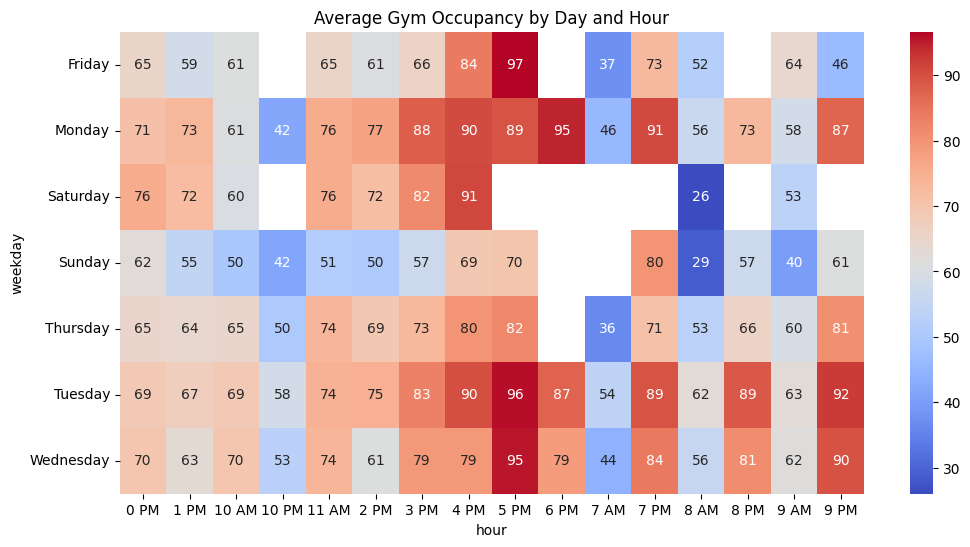

In [14]:
# Visualization example
plt.figure(figsize=(12, 6))
sns.heatmap(
    heatmap_pivot,
    cmap='coolwarm', annot=True
)
plt.title('Average Gym Occupancy by Day and Hour')